**IMPORTING LIBRARIES**

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**DATA LOADING**

In [9]:
def verify_and_read_data():
    try:
        import os
        print("Available directories:", os.listdir("../input"))
        
        file_path = '/kaggle/input/us-accidents/US_Accidents_March23.csv'
        
        df = pd.read_csv(file_path)
        
        df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
        
        df = df.dropna(subset=['Start_Time'])
        
        print(f"Data loaded successfully! Shape: {df.shape}")
        return df
        
    except FileNotFoundError:
        print("Error: File not found. Please check the path.")
        return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

**DATA CLEANING**

In [10]:
def clean_data(df):
    try:
        
        columns_to_drop = ['ID', 'Source', 'End_Time', 'Description', 'Street', 'City', 
                          'County', 'Zipcode', 'Country', 'Timezone']
        df = df.drop(columns=columns_to_drop)
        
        
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        categorical_columns = df.select_dtypes(include=['object']).columns
        
        
        for col in numeric_columns:
            df[col].fillna(df[col].median(), inplace=True)
        
        
        for col in categorical_columns:
            df[col].fillna(df[col].mode()[0], inplace=True)
            
        print("Data cleaning completed successfully!")
        return df
        
    except Exception as e:
        print(f"Error in data cleaning: {str(e)}")
        return None

**FEATURE ENGINEERING**

In [15]:

def engineer_features(df):
    try:
        
        print(f"Start_Time dtype: {df['Start_Time'].dtype}")
        
        
        df['Hour'] = df['Start_Time'].dt.hour
        df['Day_of_Week'] = df['Start_Time'].dt.dayofweek
        df['Month'] = df['Start_Time'].dt.month
        df['Year'] = df['Start_Time'].dt.year
        df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)
        
        
        df['Time_of_Day'] = pd.cut(df['Hour'], 
                                  bins=[0, 6, 12, 18, 24], 
                                  labels=['Night', 'Morning', 'Afternoon', 'Evening'])
        
        
        df = df.drop('Start_Time', axis=1)
        
        
        weather_mapping = {
            'Clear': 'Clear',
            'Fair': 'Clear',
            'Mostly Clear': 'Clear',
            'Partly Cloudy': 'Cloudy',
            'Cloudy': 'Cloudy',
            'Overcast': 'Cloudy',
            'Rain': 'Rain',
            'Heavy Rain': 'Rain',
            'Light Rain': 'Rain',
            'Snow': 'Snow',
            'Light Snow': 'Snow',
            'Heavy Snow': 'Snow',
            'Thunderstorm': 'Thunderstorm'
        }
        
        
        df['Weather_Condition'] = df['Weather_Condition'].fillna('Unknown')
        df['Weather_Condition'] = df['Weather_Condition'].apply(
            lambda x: next((v for k, v in weather_mapping.items() if k.lower() in str(x).lower()), 'Other'))
        
        
        weather_severity = {
            'Clear': 0, 
            'Cloudy': 1, 
            'Rain': 2, 
            'Snow': 3, 
            'Thunderstorm': 4, 
            'Other': 1,
            'Unknown': 1
        }
        df['Weather_Severity'] = df['Weather_Condition'].map(weather_severity)
        
        print("Feature engineering completed successfully!")
        return df
        
    except Exception as e:
        print(f"Error in feature engineering: {str(e)}")
        print(f"Error location: {e.__traceback__.tb_lineno}")
        return None


**EXPLORATORY DATA ANALYSIS**

In [14]:
def perform_eda(df):
    try:
        plt.figure(figsize=(15, 10))
        
        
        plt.subplot(2, 2, 1)
        sns.countplot(data=df, x='Severity')
        plt.title('Distribution of Accident Severity')
        
       r̥
        plt.subplot(2, 2, 2)
        sns.boxplot(data=df, x='Time_of_Day', y='Severity')
        plt.title('Severity by Time of Day')
        
        
        plt.subplot(2, 2, 3)
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        correlation_matrix = df[numeric_cols].corr()['Severity'].sort_values()
        sns.heatmap(correlation_matrix.to_frame(), cmap='coolwarm', annot=True)
        plt.title('Feature Correlations with Severity')
        
        plt.tight_layout()
        plt.show()
        
        print("EDA completed successfully!")
        
    except Exception as e:
        print(f"Error in EDA: {str(e)}")


**MODEL PREPARATION**

In [13]:
def prepare_data_for_modeling(df):
    try:
        
        X = df.drop('Severity', axis=1)
        y = df['Severity']
        
        
        bool_columns = X.select_dtypes(include=['bool']).columns
        for col in bool_columns:
            X[col] = X[col].astype(int)
        
        
        categorical_columns = X.select_dtypes(include=['object']).columns
        le = LabelEncoder()
        for col in categorical_columns:
            X[col] = le.fit_transform(X[col].astype(str))
        
       
        print("\nColumn dtypes after encoding:")
        print(X.dtypes.value_counts())
        
        
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        
        
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.167, random_state=42)
        
        print("\nTraining set shape:", X_train.shape)
        print("Validation set shape:", X_val.shape)
        print("Test set shape:", X_test.shape)
        
        print("Data preparation completed successfully!")
        return X_train, X_val, X_test, y_train, y_val, y_test
        
    except Exception as e:
        print(f"Error in data preparation: {str(e)}")
        print("Columns causing issues:")
        for col in X.columns:
            print(f"{col}: {X[col].dtype}")
        return None

**MODEL TRAINING**

In [12]:
def train_and_evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test):
    try:
        
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        
        
        y_val_pred = rf_model.predict(X_val)
        y_test_pred = rf_model.predict(X_test)
        
        
        print("\nValidation Set Results:")
        print(classification_report(y_val, y_val_pred))
        
        
        print("\nTest Set Results:")
        print(classification_report(y_test, y_test_pred))
        
        
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
        plt.title('Top 10 Most Important Features')
        plt.show()
        
        return rf_model
        
    except Exception as e:
        print(f"Error in model training and evaluation: {str(e)}")
        return None


**MAIN EXECUTION**

Available directories: ['us-accidents']
Data loaded successfully! Shape: (6985228, 46)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 6985228 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               object        
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            object        
 11  Street                 object        
 12  City                   object        
 13  County                 object        
 14  State                  object        
 15  Zipcode                object        
 16  Country    

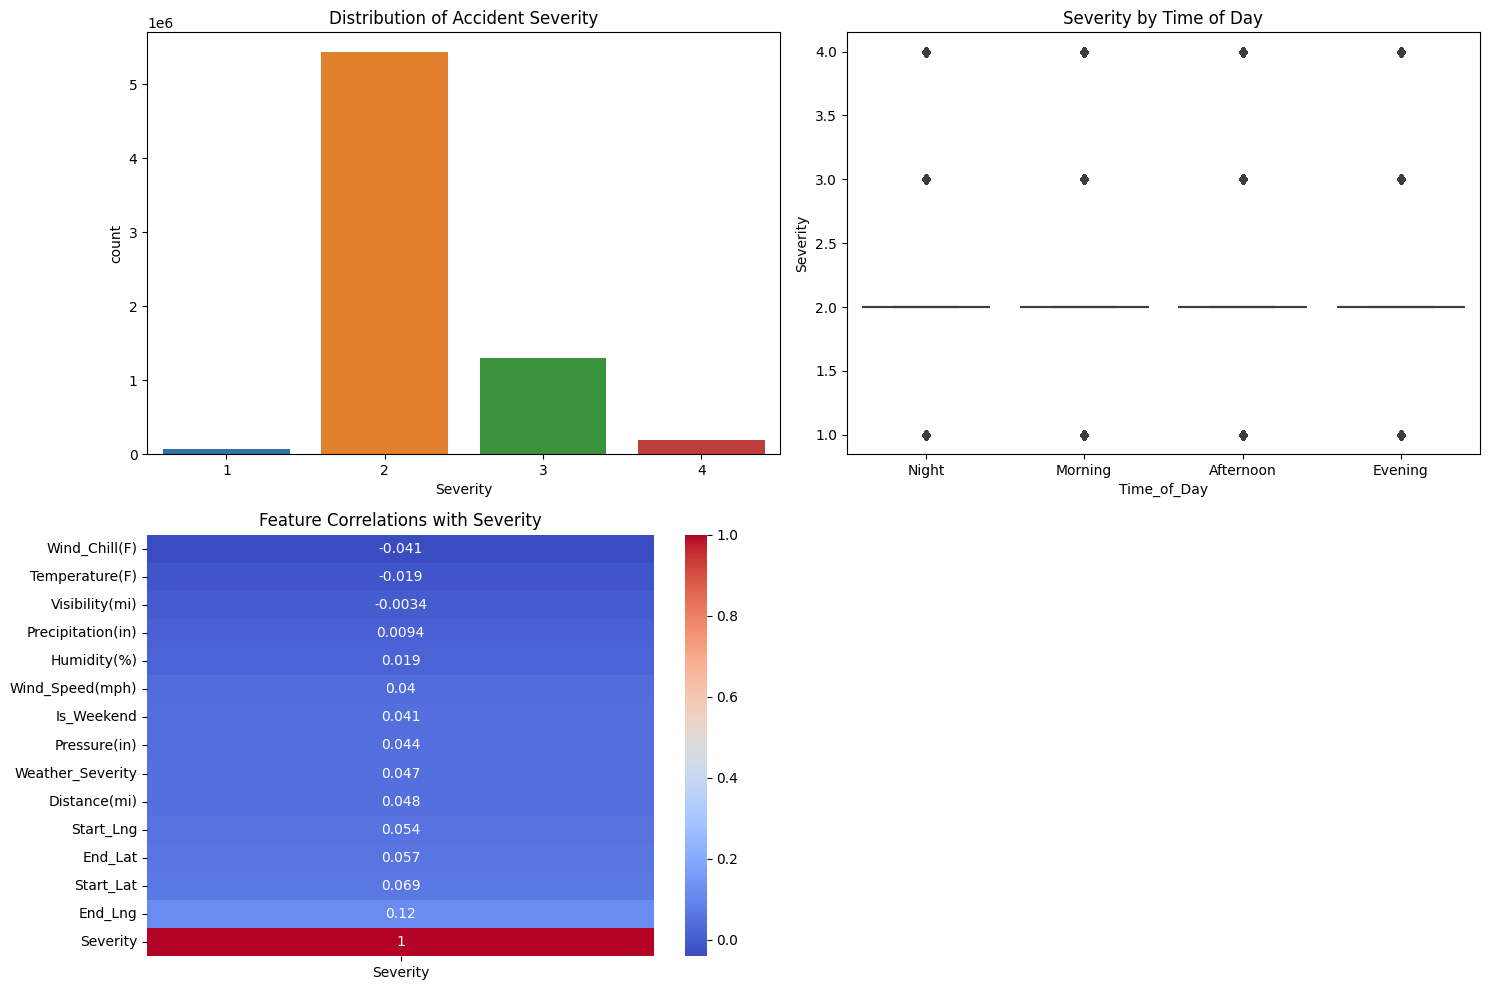

EDA completed successfully!

Column dtypes after encoding:
int64       24
float64     12
int32        4
category     1
Name: count, dtype: int64
Error in data preparation: could not convert string to float: 'Night'
Columns causing issues:
Start_Lat: float64
Start_Lng: float64
End_Lat: float64
End_Lng: float64
Distance(mi): float64
State: int64
Airport_Code: int64
Weather_Timestamp: int64
Temperature(F): float64
Wind_Chill(F): float64
Humidity(%): float64
Pressure(in): float64
Visibility(mi): float64
Wind_Direction: int64
Wind_Speed(mph): float64
Precipitation(in): float64
Weather_Condition: int64
Amenity: int64
Bump: int64
Crossing: int64
Give_Way: int64
Junction: int64
No_Exit: int64
Railway: int64
Roundabout: int64
Station: int64
Stop: int64
Traffic_Calming: int64
Traffic_Signal: int64
Turning_Loop: int64
Sunrise_Sunset: int64
Civil_Twilight: int64
Nautical_Twilight: int64
Astronomical_Twilight: int64
Hour: int32
Day_of_Week: int32
Month: int32
Year: int32
Is_Weekend: int64
Time_of_D

In [38]:
def main():
    
    df = verify_and_read_data()
    if df is None:
        return
        
    
    print("\nDataset Info:")
    print(df.info())
    
    
    df = clean_data(df)
    if df is None:
        return
    
    
    df = engineer_features(df)
    if df is None:
        return
    
    
    perform_eda(df)
    
    
    model_data = prepare_data_for_modeling(df)
    if model_data is None:
        return
    X_train, X_val, X_test, y_train, y_val, y_test = model_data
    
    
    model = train_and_evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test)

if __name__ == "__main__":
    main()

In [46]:

data = load_iris()
X, y = data.data, data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


test_accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


y_test_pred = model.predict(X_test)
detailed_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Detailed Test Accuracy: {detailed_accuracy:.4f}")

Test Accuracy: 1.0000
Detailed Test Accuracy: 1.0000


**Recommendations**
* Error Handling: Ensure data types are consistent. The script encountered issues with string-to-float conversion during data preparation.
* Imbalanced Data: Address class imbalance in the Severity column using techniques like SMOTE or class weights.
* Model Comparison: Experiment with other models (e.g., Gradient Boosting, Neural Networks
* in short summary code with results display